In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import ffmpeg
import whisper
import torch
from torch.distributions import Categorical
import numpy as np
from whisper.tokenizer import get_tokenizer
from whisper import audio

In [58]:
# fn = "/tmp/perkins.avi [uS78f4WUbXs].webm" # https://www.youtube.com/watch?v=uS78f4WUbXs
fn = "/tmp/Phasmophobia： No Evidence [QoDTqAwskPU].opus" # https://www.youtube.com/watch?v=QoDTqAwskPU
data, _ = ffmpeg.input(fn).output('-', format='s16le', acodec='pcm_s16le', ac=1, ar='16k').run(quiet=True, input='')
data = np.frombuffer(data, np.int16).astype(np.float32) / 32768.0
model = whisper.load_model("tiny")
model = model.to("cpu")
tokenizer = get_tokenizer(model.is_multilingual, language='en')

In [59]:
import gc
@torch.no_grad()
def transcribe(model, data, **kwargs):
    language = kwargs['language']
    tokenizer = get_tokenizer(model.is_multilingual, language=kwargs['language'] if 'language' in kwargs else 'en')
    batches, beams = 2, 1
    overlap = 5
    left = 30 - overlap
    for i in range(0, data.shape[0], left * 16000 * batches):
        x = data[i:i+left * 16000 * batches + overlap * 16000]
        mel = audio.log_mel_spectrogram(x)
        mels = []
        for k in range(batches):
            chunk = mel[:, k * left*100: k * left*100 + 3000]
            if chunk.shape[-1] == 0: break
            if chunk.shape[-1] < 3000: chunk = audio.pad_or_trim(chunk, audio.N_FRAMES)
            mels.append(chunk.unsqueeze(0))
        mels = torch.concat(mels, dim=0)

        initial = [*tokenizer.sot_sequence]
        tokens = torch.tensor(initial).repeat(mels.shape[0]*beams, 1)
        audio_features = model.encoder(mels).repeat_interleave(beams, dim=0)
        print(tokens.shape)
        next_tokens = tokens
        logitsc = torch.tensor([])
        kv_cache, hooks = model.install_kv_cache_hooks()
        while not (tokens[:, -1] == tokenizer.eot).all():
            logits = model.decoder(next_tokens, audio_features, kv_cache=kv_cache)[:, -1:, ]
            logitsc = torch.concat([logitsc, logits[:, :, :tokenizer.timestamp_begin-1].detach()], dim=-2)
            logits[:, :, tokenizer.timestamp_begin+1: tokenizer.timestamp_begin + int(28 // 0.02)] = -np.inf
            # next_tokens = Categorical(logits=logits/0.2).sample()
            next_tokens = logits.argmax(-1)
            next_tokens[tokens[:, -1] == tokenizer.eot] = tokenizer.eot
            tokens = torch.concat([tokens, next_tokens], dim=-1)
        for t in tokens.tolist():
            print(tokenizer.decode_with_timestamps(t))
        print(tokens.shape, logitsc.shape)
        for h in hooks: h.remove()
        kv_cache.clear()
        if (i//(left * 16000 * batches)) >= 0: # HACK for testing
            logitsc, logitscs = logitsc[:-1].softmax(-1), logitsc[1:].log_softmax(-1)
            sm = torch.zeros((batches-1, tokens.shape[-1]-len(initial), tokens.shape[-1]-len(initial)))
            # sm = (logitsc * logitscs).sum(-1) # The dream
            for i in range(tokens.shape[-1]-len(initial)):
                for j in range(tokens.shape[-1]-len(initial)):
                    sm[..., i, j] = (logitsc[:, i] * logitscs[:, j]).sum(-1)
            return tokens.detach().numpy(), sm.detach().numpy()

torch.Size([2, 3])
<|startoftranscript|><|en|><|transcribe|><|0.00|> Boy do I love lights which is love turning them on and off so much fun. I love turning on lights next to my large collection of throwable objects and also empty notebooks. It was sure wood suck if someone named Carol Thomas showed up to ruin all my fun Carol Thomas Carol Thomas Carol Thomas Hey, I'm been here for like half an hour. Can we please just call this shade and go home? We need at least one piece of evidence. I do we though. I feel like the evidence is pretty conclusive. Let's go through the checklist. I'm already done the checklist.<|29.24|><|29.24|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
<|startoftranscript|><|en|><|transcribe|><|0.00|> Like the evidence is pretty conclusive. What's going through the checklist? I'm 

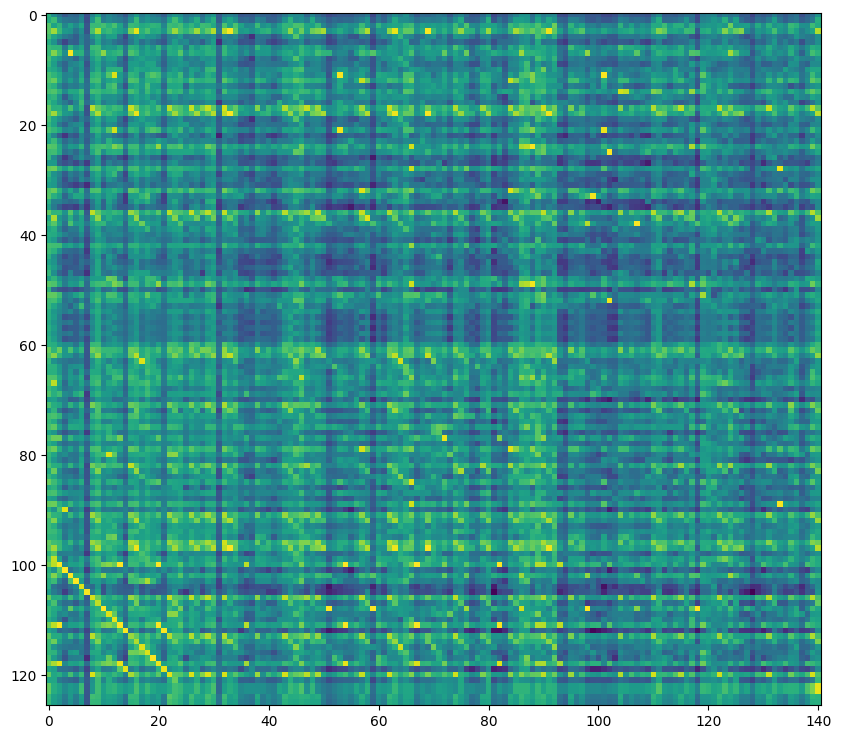

In [60]:
import gc
gc.collect()
tokens, sm = transcribe(model, data, language='en')
gc.collect()
tokens = tokens.tolist()
eot0 = len(tokens[0]) if tokenizer.eot not in tokens[0] else tokens[0].index(tokenizer.eot)
eot1 = len(tokens[1]) if tokenizer.eot not in tokens[1] else tokens[1].index(tokenizer.eot)

# Will this work for batches > 2? probably not
# Long chains of end tokens match very similarily to each other
sm = sm[:, :eot0, :eot1]
print(tokens[0][len(tokenizer.sot_sequence):])
print(tokens[1][len(tokenizer.sot_sequence):])
plt.figure(figsize=(10, 10))
plt.imshow(sm[-1])

-17.558535017073154 15.0 112 14


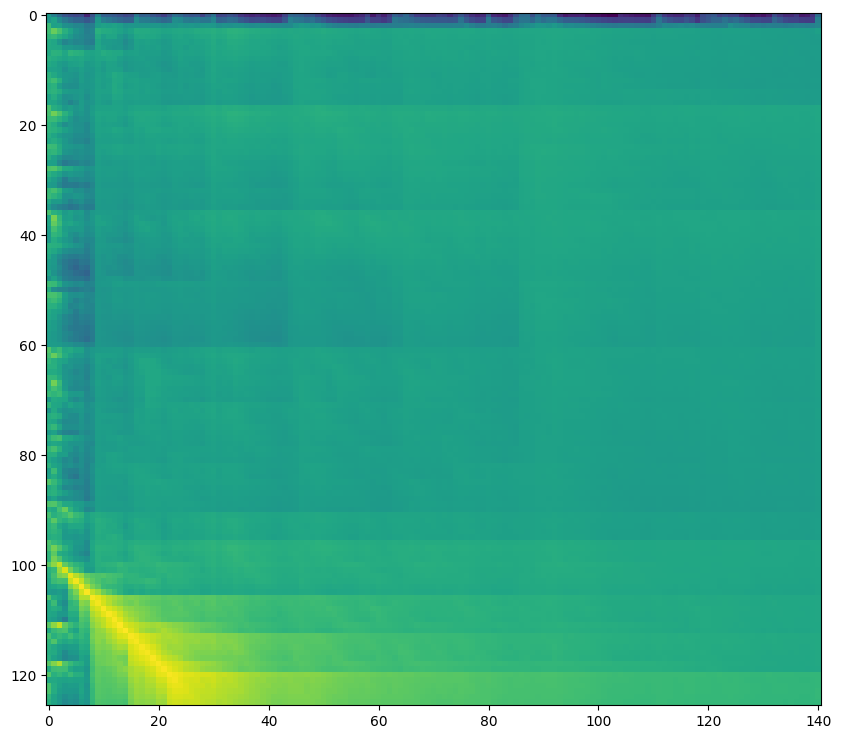

In [61]:
memo = {}
fm, fl, fmi, fmj = -np.inf, 1, 0, 0
for i in range(sm.shape[-2]):
    for j in range(sm.shape[-1]):
        z = [memo.get(d, (0, 0)) for d in [(i-1, j), (i, j-1), (i-1, j-1)]]
        scores, lens = np.array(list(zip(*z)))
        ns = scores + sm[0, i, j]
        f = (ns/(lens+1)).argmax()
        memo[i, j] = (ns[f], lens[f]+1)
        if (memo[i, j][0]/memo[i, j][1]) > (fm/fl): fm, fl, fmi, fmj = memo[i, j][0], memo[i, j][1], i, j
            
print(fm, fl, fmi, fmj)
scores = [[0 for j in range(sm.shape[-1])] for i in range(sm.shape[-2])]
for i in range(sm.shape[-2]):
    for j in range(sm.shape[-1]):
        scores[i][j] = memo[i, j][0]/memo[i, j][1]
plt.figure(figsize=(10, 10))
plt.imshow(scores)

In [62]:
dirs = [(-1, 0), (0, -1), (-1, -1)]
ci, cj = fmi, fmj
l = memo[ci, cj][1]
trace = []
z = [i for i in range(len(dirs))]
while l > 1:
    trace.append((ci, cj))
    d = sorted(z, key=lambda x: memo.get((ci+dirs[x][0], cj+dirs[x][1]), (-np.inf,))[0])[-1] # argmax
    di, dj = dirs[d]
    ci, cj = ci+di, cj+dj
    l -= 1
print(trace)

[(112, 14), (111, 13), (110, 12), (109, 11), (108, 10), (107, 9), (106, 8), (105, 7), (104, 6), (103, 5), (102, 4), (101, 3), (100, 2), (100, 1)]


In [63]:
f, s = list(zip(*trace))
print(f)
print(s)
print(tokenizer.decode_with_timestamps(tokens[0][len(tokenizer.sot_sequence):][f[-1]:f[0]]))
print(tokenizer.decode_with_timestamps(tokens[1][len(tokenizer.sot_sequence):][s[-1]:s[0]]))

(112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 100)
(14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1)
 the evidence is pretty conclusive. Let's go through the
 Like the evidence is pretty conclusive. What's going through the
